# Tests and Examples for  *pred_help*
### Classifier, Results , NamedTuples and help functions

In [1]:
# Notebook setup (initially %load(ed) from 'notebook_setup.py')
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Set these (even tho they get re-set) to placate PyCharm
data_dir = None
models_dir = None

import numpy as np
from   pathlib import Path
# mcs utilities and helpers
from   ms_util import *

#Project Setup - Names & Commonly Used Values
project_name   = 'test_pred_help'   # Used as prefix for several derived names below
model_name     = 'resnet50'
model_arch     = 'Resnet50'   # Resnet50 , Resnet34, etc ...
img_size       = 300
batch_size     = 32

%run -i {user_lib}/finish_setup.py --show Proj

data_dir        =  /Volumes/ArielD/storage/data
data_root       =  /Volumes/ArielD/storage
proj_data_dir   =  /Volumes/ArielD/storage/data/test_pred_help
project_name    =  test_pred_help
proj_data_dir   =  /Volumes/ArielD/storage/data/test_pred_help
proj_dir        =  /Users/mcsieber/storage/notebooks/test_pred_help
models_dir      =  /Volumes/ArielD/storage/data/test_pred_help/models
model_name      =  resnet50
model_arch      =  Resnet50
img_size        =  300
batch_size      =  32



### Additional Setup

In [2]:
from PIL import Image
from PIL import ImageOps
from pred_help import *
from coreml_help import *
mlmodels_dir = data_dir/'mlmodels'  # Where to find downloaded CoreML models
resize_method = Image.NEAREST       # How to resample images when they are resized

#### Get test images

In [25]:
test_root     = data_root/'data'
test_data_dir = data_dir/'test'
imagenet_dir  = data_dir/'imagenet'
imagenet_path = imagenet_dir/'img_net_labels.txt'
#
dogcat_dir    = test_root/'dogscats/large/valid-large'
fruit_dir     = test_root/'food_poc/data'
food_dir      = Path('/Volumes/ArielD/storage/data/food/images')
#
img_per_dir = 3  # Get this many images per directory
max_sample  = 400    # Max sample range (set limit in case it is a huge directory)
#
t0 = get_rand_images(food_dir,   n_images=img_per_dir, search_limit=max_sample)
t1 = get_rand_images(dogcat_dir, n_images=img_per_dir, search_limit=max_sample)
t2 = get_rand_images(fruit_dir,  n_images=img_per_dir, search_limit=max_sample)
test_imgs = t0+t1+t2
#
vimg_path  = Path('/Volumes/ArielD/storage/data/food_poc/data/apples/apple_029.jpg')
vimg300    = ImageOps.fit(Image.open(vimg_path),(300,300), method=resize_method, centering=(0.5,0.4))
vimg224    = ImageOps.fit(Image.open(vimg_path),(224,224), method=resize_method, centering=(0.5,0.4))
print(f"{len(test_imgs)} test images")
pp((dogcat_dir, food_dir,fruit_dir))

22 test images
dogcat_dir     =  PosixPath('/Volumes/ArielD/storage/data/dogscats/large/valid-large')
food_dir       =  PosixPath('/Volumes/ArielD/storage/data/food/images')
fruit_dir      =  PosixPath('/Volumes/ArielD/storage/data/food_poc/data')


**Imagenet Class Labels** - Load the class labels from a disk file .These are the [1000 class labels](https://s3.amazonaws.com/onnx-model-zoo/synset.txt) for ImageNet.

In [4]:
with open(imagenet_path, 'r') as list_ : 
    inet_labels = [line.rstrip() for line in list_ ]

#### `imageRepo` named tuple - Validate

In [65]:
pp((type(imagenet), imagenet.mean, imagenet.std, imagenet.labels_url))

type(imagenet  = 
{   'count': "<method 'count' of 'tuple' objects>",
    'index': "<method 'index' of 'tuple' objects>",
    'labels_url': '<property object at 0x10e862688>',
    'mean': '<property object at 0x10e862318>',
    'std': '<property object at 0x10e862638>'}

imagenet.mean  = 
[0.485, 0.456, 0.406]

imagenet.std   = 
[0.229, 0.224, 0.225]

 imagenet.labels_url =  'https://s3.amazonaws.com/onnx-model-zoo/synset.txt'


For CoreML from ONNX, calculate scale and bias to reproduce normalization

In [5]:
mean = imagenet.mean
std  = imagenet.std

ppargs = dict(
    image_scale= 1/(255.0*std.mean()),
    red_bias   = - mean[0]/std[0],
    green_bias = - mean[1]/std[1],
    blue_bias  = - mean[2]/std[2]
)
ppargs

{'image_scale': 0.01735207357279195,
 'red_bias': -2.1179039301310043,
 'green_bias': -2.0357142857142856,
 'blue_bias': -1.8044444444444445}

### *Pred* functions - test
And instantiate models for later tests

### ONNX
Load [ONNX Resnet50(v2)](https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz) model and check that it works. This model was downloaded from the [ONNX Model Zoo](https://github.com/onnx/models)

In [5]:
import onnx
import onnxruntime as ort

onnxm_name   = 'resnet50.onnx'
onnxm_path   = data_dir/'onnx/resnet50v2'/onnxm_name ; onnxm_path

onnxm = onnx.load(onnxm_path)
onnx.checker.check_model(onnxm)

onnx_rt  = ort.InferenceSession(onnxm_path.as_posix())
pred     = pred_for_onnx(onnx_rt,vimg300,labels=inet_labels)

#### `ImagePrediction` named tuple  - validate

In [54]:
pp((type(pred), pred.topI, pred.topP, pred.topL))

type(pred      = 
{   'count': "<method 'count' of 'tuple' objects>",
    'index': "<method 'index' of 'tuple' objects>",
    'topI': '<property object at 0x10e862048>',
    'topL': '<property object at 0x10e862278>',
    'topP': '<property object at 0x10e862228>'}

pred.topI      = 
array([ 54, 703, 640])

pred.topP      = 
array([0.433 , 0.1739, 0.0906])

 pred.topL     = 
['Granny Smith', 'pomegranate', 'orange']



#### `show_pred` function - Test 

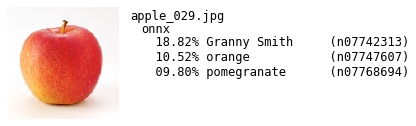

In [6]:
show_pred(vimg_path,pred,model_id='onnx');

### Torch
Load and check a standard Torch Resnet50

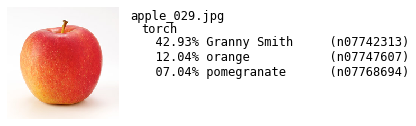

In [8]:
import torch
import torchvision

torchm_name = 'torch.pth'
torchm_path = models_dir/torchm_name

torchm = torchvision.models.resnet50(pretrained=True)
torchm.eval()  # Must set to evaluation mode to generate predictions

pred = pred_for_torch(torchm,vimg300,labels=inet_labels)
show_pred(vimg_path,pred, model_id='torch');

### CoreML
CML - Load and check a standard CoreML Resnet50 model


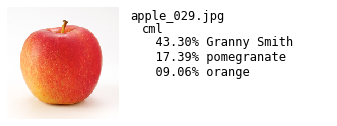

In [9]:
coreml_name = 'Resnet50.mlmodel'
coreml_path = mlmodels_dir/'Resnet50'/coreml_name
cml  = cm.MLModel(coreml_path.as_posix())
pred = pred_for_coreml(cml,vimg224)
show_pred(vimg_path,pred, model_id='cml');

## Predictions
For each of the test images, generate a prediction from each of the models and save the results.

In [78]:
models_params = { 
        'torch': PredParams(func=pred_for_torch, runtime=torchm, imgsize=300, labels=inet_labels),
        'onnx' : PredParams(func=pred_for_onnx,  runtime=onnx_rt,imgsize=300, labels=inet_labels),
        'cml'  : PredParams(func=pred_for_coreml,runtime=cml,    imgsize=224, labels= None)
    # additional models would go here
}

#### `PredParams` named tuple - Validate

In [79]:
torch_pred_params = models_params['torch']
t = torch_pred_params

In [80]:
pp((type(t), t.func, t.imgsize, t.index, len(t.labels), type(t.runtime)))

type(t         = 
{   'count': "<method 'count' of 'tuple' objects>",
    'func': '<property object at 0x10e8627c8>',
    'imgsize': '<property object at 0x10e862b38>',
    'index': "<method 'index' of 'tuple' objects>",
    'labels': '<property object at 0x10e862b88>',
    'runtime': '<property object at 0x10e862ae8>'}

t.func         =  <function pred_for_torch at 0x10e85a158>
t.imgsize      =  300
t.index        =  <built-in method index of PredParams object at 0x14432b678>
len(t.labels)  =  1000
 type(t.runtime =  <class 'torchvision.models.resnet.ResNet'>


#### Classifier - Validate `Classifier` creation

In [81]:
models = Classifier(params=models_params,top_count=3)
m = models
pp((m.model_list,m.model_dict,len(models.pred_params),m.num_models,m.num_imgs,m.resize_method, m.top_count))

m.model_list   = 
['torch', 'onnx', 'cml']

m.model_dict   = 
{'cml': 2, 'onnx': 1, 'torch': 0}

len(models.pred_params) =  3
m.num_models   =  3
m.num_imgs     =  8
m.resize_method =  0
 m.top_count   =  3


#### Classifier - Validate prediction generation and capture
Get predictions on each test image from all models and save the results  

In [82]:
models.classify(test_imgs);

0 of 22 processed, most recent is roots_081.jpg
16 of 22 processed, most recent is burger_112.jpg
Total of 22 images processed


In [83]:
pp((m.num_imgs, len(m.top_probs), len(m.top_classes), len(m.results), m.stat_int))

m.num_imgs     =  22
len(m.top_probs) =  3
len(m.top_classes) =  3
len(m.results) =  22
 m.stat_int    =  16


#### Results - Validate `Results` creation

In [84]:
results = Results(models)
r = results

In [85]:
pp((r.resize_method, len(r.results),r.results_len, r.fontsize, r.fontfamily, r.pred2show, r.model_list, r.figsize, r.imgsize))

r.resize_method =  0
len(r.results) =  22
r.results_len  =  22
r.fontsize     =  12
r.fontfamily   =  'monospace'
r.pred2show    =  2
r.model_list   = 
['torch', 'onnx', 'cml']

r.figsize      = 
(3.0, 3.5)

 r.imgsize     = 
(224, 224)



#### Results - Test methods

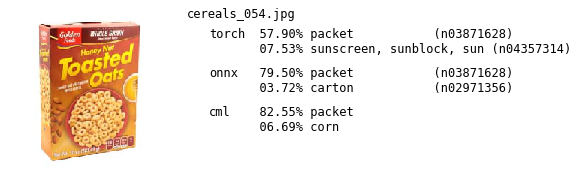

In [86]:
results.show(12)

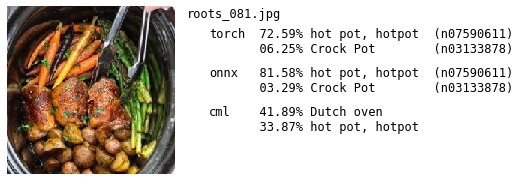

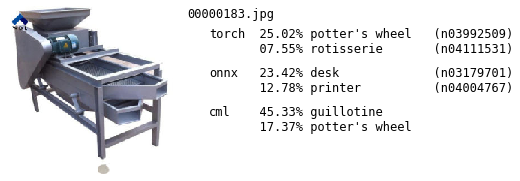

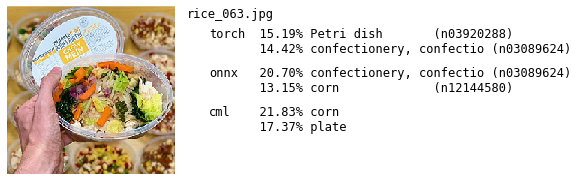

In [87]:
results.show([0,2,7])


Showing results [0, 8, 18, 19, 21] 
  and top 2 probabilities for each model


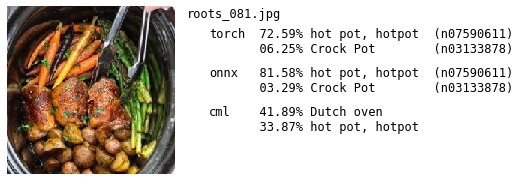

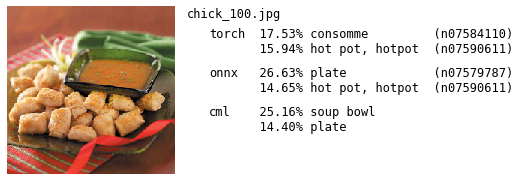

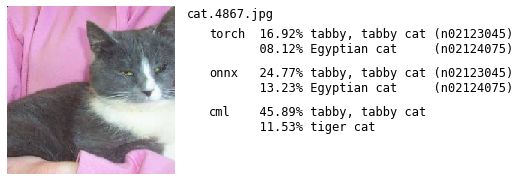

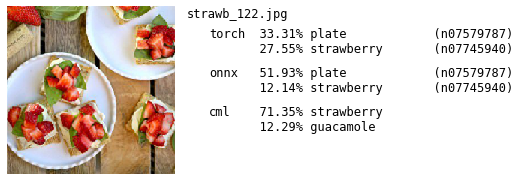

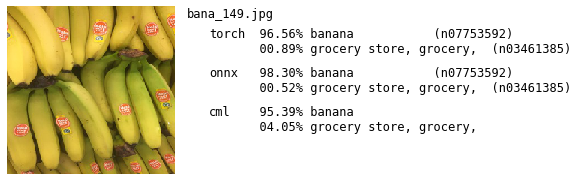

In [89]:
results.show_random()